In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from datetime import datetime

In [3]:
df = pd.read_csv('BTCUSDT-trades-2023-10.csv')
df=df.sort_values(by='time')
df['time'] = pd.to_datetime(df['time'], unit='ms')
df=df.set_index('time')
df

,id,price,qty,quote_qty,is_buyer_maker
time,,,,,
2023-10-01 00:00:04.732,4130731517,26951.0,0.003,80.8530,False
2023-10-01 00:00:04.758,4130731518,26950.9,0.005,134.7545,True
2023-10-01 00:00:04.760,4130731519,26951.0,0.001,26.9510,False
2023-10-01 00:00:04.769,4130731520,26950.9,0.023,619.8707,True
2023-10-01 00:00:04.771,4130731521,26951.0,0.001,26.9510,False
...,...,...,...,...,...
2023-10-31 23:59:59.430,4244484016,34651.4,0.001,34.6514,False
2023-10-31 23:59:59.430,4244484017,34651.4,0.005,173.2570,False
2023-10-31 23:59:59.430,4244484018,34651.4,0.025,866.2850,False


In [4]:
df1=df.resample('1T').mean()

In [5]:
df1=df1[['price','qty','quote_qty']]
df1

,price,qty,quote_qty
time,,,
2023-10-01 00:00:00,26947.742090,0.065988,1778.220758
2023-10-01 00:01:00,26946.584265,0.116204,3131.286408
2023-10-01 00:02:00,26943.490519,0.113290,3052.391340
2023-10-01 00:03:00,26944.953152,0.058297,1570.821979
2023-10-01 00:04:00,26949.811582,0.078444,2113.997902
...,...,...,...
2023-10-31 23:55:00,34656.628150,0.056430,1955.713806
2023-10-31 23:56:00,34657.147881,0.053028,1837.739716
2023-10-31 23:57:00,34669.063308,0.058674,2034.241904


In [27]:
df1.to_csv('resample_10.csv', index=True)  # 'output.csv'에 저장, 인덱스도 함께 저장

In [6]:
def convert_tick_to_ohlcv(data):
    """
    Converts given Binance tick data into 1-hour interval OHLCV (Open, High, Low, Close, Volume) data.
    :param data: DataFrame with Tick data
    :return: DataFrame with the Open, High, Low, Close, Volume values
    """
    ohlcv = data.resample('1T').agg({
        'price': ['first', 'max', 'min', 'last'],
        'qty': 'sum'
})

    ohlcv.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    return ohlcv

def calculate_volatility(data, window=20):
    """
    Calculate the rolling volatility using the standard deviation of returns.
    :param data: DataFrame with OHLCV data
    :param window: The number of periods to use for calculating the standard deviation
    :return: DataFrame with the volatility values
    """

    # Calculate daily returns
    data['returns'] = data['Close'].pct_change()

    # Calculate the rolling standard deviation of returns
    data['volatility'] = data['returns'].rolling(window=window).std()
    return data

In [7]:
ohlcv=convert_tick_to_ohlcv(df)
ohlcv

,Open,High,Low,Close,Volume
time,,,,,
2023-10-01 00:00:00,26951.0,26951.0,26946.4,26948.7,68.826
2023-10-01 00:01:00,26948.6,26948.7,26944.3,26945.6,89.361
2023-10-01 00:02:00,26945.7,26945.8,26942.0,26942.1,100.375
2023-10-01 00:03:00,26942.1,26946.8,26942.0,26945.1,40.691
2023-10-01 00:04:00,26945.1,26956.3,26945.1,26956.3,75.855
...,...,...,...,...,...
2023-10-31 23:55:00,34670.5,34671.0,34641.6,34667.4,128.095
2023-10-31 23:56:00,34667.4,34667.4,34646.4,34660.4,100.116
2023-10-31 23:57:00,34660.4,34677.0,34660.3,34677.0,69.881


In [8]:
result=calculate_volatility(ohlcv, window=20)
result

,Open,High,Low,Close,Volume,returns,volatility
time,,,,,,,
2023-10-01 00:00:00,26951.0,26951.0,26946.4,26948.7,68.826,NaN,NaN
2023-10-01 00:01:00,26948.6,26948.7,26944.3,26945.6,89.361,-0.000115,NaN
2023-10-01 00:02:00,26945.7,26945.8,26942.0,26942.1,100.375,-0.000130,NaN
2023-10-01 00:03:00,26942.1,26946.8,26942.0,26945.1,40.691,0.000111,NaN
2023-10-01 00:04:00,26945.1,26956.3,26945.1,26956.3,75.855,0.000416,NaN
...,...,...,...,...,...,...,...
2023-10-31 23:55:00,34670.5,34671.0,34641.6,34667.4,128.095,-0.000087,0.000318
2023-10-31 23:56:00,34667.4,34667.4,34646.4,34660.4,100.116,-0.000202,0.000304
2023-10-31 23:57:00,34660.4,34677.0,34660.3,34677.0,69.881,0.000479,0.000314


* resample 하고 21행부터 가져오기

In [9]:
result2=result.iloc[21:]
result2

,Open,High,Low,Close,Volume,returns,volatility
time,,,,,,,
2023-10-01 00:21:00,26962.6,26962.6,26952.1,26952.2,43.429,-0.000386,0.000180
2023-10-01 00:22:00,26952.2,26952.2,26952.1,26952.2,10.259,0.000000,0.000176
2023-10-01 00:23:00,26952.2,26956.0,26952.1,26955.9,43.480,0.000137,0.000177
2023-10-01 00:24:00,26955.9,26958.0,26955.9,26958.0,20.611,0.000078,0.000152
2023-10-01 00:25:00,26958.0,26959.7,26957.9,26959.7,11.561,0.000063,0.000152
...,...,...,...,...,...,...,...
2023-10-31 23:55:00,34670.5,34671.0,34641.6,34667.4,128.095,-0.000087,0.000318
2023-10-31 23:56:00,34667.4,34667.4,34646.4,34660.4,100.116,-0.000202,0.000304
2023-10-31 23:57:00,34660.4,34677.0,34660.3,34677.0,69.881,0.000479,0.000314


C:\Users\haeun\anaconda3\Lib\site-packages\seaborn\categorical.py:486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(data[0]):


<Axes: >

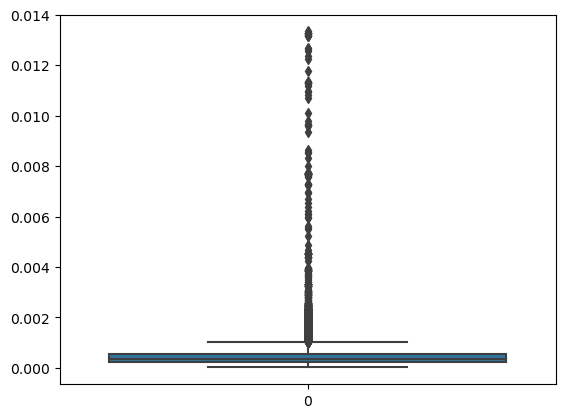

In [10]:
sns.boxplot(result2.volatility)

* 이상치 제거

In [11]:
def replace_outlier(value):
    Q1 = result2['volatility'].quantile(0.25)
    Q3 = result2['volatility'].quantile(0.75)
    IQR = Q3-Q1
    rev_range = 3

    if((value <(Q1-rev_range*IQR))):
        value = np.nan
    if((value >(Q3+rev_range*IQR))):
        value = np.nan
    return value

result2['volatility'] = result2['volatility'].apply(replace_outlier)

C:\Users\haeun\AppData\Local\Temp\ipykernel_10288\1537720560.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result2['volatility'] = result2['volatility'].apply(replace_outlier)


In [12]:
result2.isna().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
returns         0
volatility    888
dtype: int64

In [13]:
result2=result2.dropna()
result2

,Open,High,Low,Close,Volume,returns,volatility
time,,,,,,,
2023-10-01 00:21:00,26962.6,26962.6,26952.1,26952.2,43.429,-0.000386,0.000180
2023-10-01 00:22:00,26952.2,26952.2,26952.1,26952.2,10.259,0.000000,0.000176
2023-10-01 00:23:00,26952.2,26956.0,26952.1,26955.9,43.480,0.000137,0.000177
2023-10-01 00:24:00,26955.9,26958.0,26955.9,26958.0,20.611,0.000078,0.000152
2023-10-01 00:25:00,26958.0,26959.7,26957.9,26959.7,11.561,0.000063,0.000152
...,...,...,...,...,...,...,...
2023-10-31 23:55:00,34670.5,34671.0,34641.6,34667.4,128.095,-0.000087,0.000318
2023-10-31 23:56:00,34667.4,34667.4,34646.4,34660.4,100.116,-0.000202,0.000304
2023-10-31 23:57:00,34660.4,34677.0,34660.3,34677.0,69.881,0.000479,0.000314


### 독립변수 : 종속변수 뺀 나머지 & 이상치 제거

In [14]:
X = result2.drop('volatility',axis=1) # 변동성 빼고 나머지 데이터 프레임
y = result2['volatility']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=222) 

In [19]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=222) # 그냥 이렇게 한번 돌려볼게
rf_model.fit(X_train, y_train) # 모델 학습

# 학습된 모델을 사용하여 테스트 데이터 예측
y_pred = rf_model.predict(X_test)

r2score = r2_score(y_true = y_test, y_pred =y_pred) ## R-squared score
mse = mean_squared_error(y_true = y_test, y_pred =y_pred) ## MSE (Mean Squared Error)
mae = mean_absolute_error(y_true = y_test, y_pred =y_pred) ## MAE (Mean Absolute Error)
mape=mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred) ## MAPE

print("r2score :", r2score)
print("mse :", mse)
print("mae :", mae)
print("mape :", mape)

r2score : 0.5533175106845627
mse : 2.9604479814923975e-08
mae : 0.0001221456216059087
mape : 0.332437716210901


In [20]:
# RandomForestRegressor 모델과 mse 기준으로 튜닝할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20]
}

# 모델 생성
rf_model = RandomForestRegressor(random_state=222)

# GridSearchCV 생성
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# 데이터에 모델을 적합시키고 최적의 하이퍼파라미터를 찾음
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", grid_search.best_params_)

최적의 하이퍼파라미터: {'max_depth': 10, 'n_estimators': 150}


In [ ]:
rf_model = RandomForestRegressor(n_estimators=150, max_depth=10,random_state=222)
rf_model.fit(X_train, y_train) # 모델 학습

# 학습된 모델을 사용하여 테스트 데이터 예측
y_pred = rf_model.predict(X_test)

r2score = r2_score(y_true = y_test, y_pred =y_pred) ## R-squared score
mse = mean_squared_error(y_true = y_test, y_pred =y_pred) ## MSE (Mean Squared Error)
mae = mean_absolute_error(y_true = y_test, y_pred =y_pred) ## MAE (Mean Absolute Error)
mape=mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred) ## MAPE

print("r2score :", r2score)
print("mse :", mse)
print("mae :", mae)
print("mape :", mape)

### -> 실행 안 됐는데 위에거보다 mse 낮아지고 mape 높아짐

In [22]:
# RandomForestRegressor 모델과 mape 기준으로 튜닝할 하이퍼파라미터 그리드 정의

# MAPE를 계산하는 함수 정의
def mape(y_true, y_pred): 
    """
    MAPE 계산 함수

    Parameters:
    - y_true: 실제값의 배열
    - y_pred: 예측값의 배열

    Returns:
    - mape: MAPE 값
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # 0으로 나누는 것을 방지하기 위해 실제값이 0인 경우는 0으로 대체
    mask = y_true != 0
    y_true, y_pred = y_true[mask], y_pred[mask]

    # MAPE 계산
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return mape

# MAPE를 사용자 정의 스코어로 등록
mape_scorer = make_scorer(mape, greater_is_better=False)

# RandomForestRegressor 모델과 튜닝할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 15, 19]
}

# 모델 생성
rf_model = RandomForestRegressor(random_state=222)

# GridSearchCV 생성
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring=mape_scorer)

# 데이터에 모델을 적합시키고 최적의 하이퍼파라미터를 찾음
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", grid_search.best_params_)


최적의 하이퍼파라미터: {'max_depth': 15, 'n_estimators': 100}


In [23]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=15,random_state=222)
rf_model.fit(X_train, y_train) # 모델 학습

# 학습된 모델을 사용하여 테스트 데이터 예측
y_pred = rf_model.predict(X_test)

r2score = r2_score(y_true = y_test, y_pred =y_pred) ## R-squared score
mse = mean_squared_error(y_true = y_test, y_pred =y_pred) ## MSE (Mean Squared Error)
mae = mean_absolute_error(y_true = y_test, y_pred =y_pred) ## MAE (Mean Absolute Error)
mape=mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred) ## MAPE

print("r2score :", r2score)
print("mse :", mse)
print("mae :", mae)
print("mape :", mape) # 이게 mape 제일 작게 나옴!!!!

r2score : 0.5634837650107715
mse : 2.893069770303758e-08
mae : 0.00012092857232150738
mape : 0.3299765925842677


### 이상치 살려보기

In [31]:
result3=result.iloc[21:]
result3

,Open,High,Low,Close,Volume,returns,volatility
time,,,,,,,
2023-10-01 00:21:00,26962.6,26962.6,26952.1,26952.2,43.429,-0.000386,0.000180
2023-10-01 00:22:00,26952.2,26952.2,26952.1,26952.2,10.259,0.000000,0.000176
2023-10-01 00:23:00,26952.2,26956.0,26952.1,26955.9,43.480,0.000137,0.000177
2023-10-01 00:24:00,26955.9,26958.0,26955.9,26958.0,20.611,0.000078,0.000152
2023-10-01 00:25:00,26958.0,26959.7,26957.9,26959.7,11.561,0.000063,0.000152
...,...,...,...,...,...,...,...
2023-10-31 23:55:00,34670.5,34671.0,34641.6,34667.4,128.095,-0.000087,0.000318
2023-10-31 23:56:00,34667.4,34667.4,34646.4,34660.4,100.116,-0.000202,0.000304
2023-10-31 23:57:00,34660.4,34677.0,34660.3,34677.0,69.881,0.000479,0.000314


In [32]:
def saving_outlier(value):
    Q1 = result3['volatility'].quantile(0.25)
    Q3 = result3['volatility'].quantile(0.75)
    IQR = Q3-Q1
    rev_range = 3

    if((value < (Q1 - rev_range*IQR))):
        value = 1
    elif((value > (Q3 + rev_range*IQR))):
        value = 1
    else:
        value = 0
    return value



In [33]:
result3['volatility'] = result3['volatility'].apply(saving_outlier)

C:\Users\haeun\AppData\Local\Temp\ipykernel_10288\1102238411.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result3['volatility'] = result3['volatility'].apply(saving_outlier)


In [34]:
result3.volatility.sum() # 이상치 888개 위랑 똑같음

888

In [35]:
X = result3.drop('volatility',axis=1) # 변동성 빼고 나머지 데이터 프레임
y = result3['volatility']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=222) 

In [37]:
# RandomForestRegressor 모델과 mape 기준으로 튜닝할 하이퍼파라미터 그리드 정의

# MAPE를 계산하는 함수 정의
def mape(y_true, y_pred): 
    """
    MAPE 계산 함수

    Parameters:
    - y_true: 실제값의 배열
    - y_pred: 예측값의 배열

    Returns:
    - mape: MAPE 값
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # 0으로 나누는 것을 방지하기 위해 실제값이 0인 경우는 0으로 대체
    mask = y_true != 0
    y_true, y_pred = y_true[mask], y_pred[mask]

    # MAPE 계산
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return mape

# MAPE를 사용자 정의 스코어로 등록
mape_scorer = make_scorer(mape, greater_is_better=False)

# RandomForestRegressor 모델과 튜닝할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20]
}

# 모델 생성
rf_model = RandomForestRegressor(random_state=222)

# GridSearchCV 생성
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring=mape_scorer)

# 데이터에 모델을 적합시키고 최적의 하이퍼파라미터를 찾음
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", grid_search.best_params_)

최적의 하이퍼파라미터: {'max_depth': 20, 'n_estimators': 200}


In [38]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=20,random_state=222)
rf_model.fit(X_train, y_train) # 모델 학습

# 학습된 모델을 사용하여 테스트 데이터 예측
y_pred = rf_model.predict(X_test)

r2score = r2_score(y_true = y_test, y_pred =y_pred) ## R-squared score
mse = mean_squared_error(y_true = y_test, y_pred =y_pred) ## MSE (Mean Squared Error)
mae = mean_absolute_error(y_true = y_test, y_pred =y_pred) ## MAE (Mean Absolute Error)
mape=mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred) ## MAPE

print("r2score :", r2score)
print("mse :", mse)
print("mae :", mae)
print("mape :", mape) # 얘가 젤 별루

r2score : 0.20675063324671827
mse : 0.014538220155541251
mae : 0.027644781703742197
mape : 67105044725248.98


* 이상치 살리면서 volatility 열에 0,1밖에 없음. y_true가 0이 된거니까 mape 개크게 나옴. 안되겠다.

### 독립변수를 시간으로

In [39]:
result4=result.iloc[21:]
result4

,Open,High,Low,Close,Volume,returns,volatility
time,,,,,,,
2023-10-01 00:21:00,26962.6,26962.6,26952.1,26952.2,43.429,-0.000386,0.000180
2023-10-01 00:22:00,26952.2,26952.2,26952.1,26952.2,10.259,0.000000,0.000176
2023-10-01 00:23:00,26952.2,26956.0,26952.1,26955.9,43.480,0.000137,0.000177
2023-10-01 00:24:00,26955.9,26958.0,26955.9,26958.0,20.611,0.000078,0.000152
2023-10-01 00:25:00,26958.0,26959.7,26957.9,26959.7,11.561,0.000063,0.000152
...,...,...,...,...,...,...,...
2023-10-31 23:55:00,34670.5,34671.0,34641.6,34667.4,128.095,-0.000087,0.000318
2023-10-31 23:56:00,34667.4,34667.4,34646.4,34660.4,100.116,-0.000202,0.000304
2023-10-31 23:57:00,34660.4,34677.0,34660.3,34677.0,69.881,0.000479,0.000314


In [40]:
result4=result4.reset_index()
result4

,time,Open,High,Low,Close,Volume,returns,volatility
0,2023-10-01 00:21:00,26962.6,26962.6,26952.1,26952.2,43.429,-0.000386,0.000180
1,2023-10-01 00:22:00,26952.2,26952.2,26952.1,26952.2,10.259,0.000000,0.000176
2,2023-10-01 00:23:00,26952.2,26956.0,26952.1,26955.9,43.480,0.000137,0.000177
3,2023-10-01 00:24:00,26955.9,26958.0,26955.9,26958.0,20.611,0.000078,0.000152
4,2023-10-01 00:25:00,26958.0,26959.7,26957.9,26959.7,11.561,0.000063,0.000152
...,...,...,...,...,...,...,...,...
44614,2023-10-31 23:55:00,34670.5,34671.0,34641.6,34667.4,128.095,-0.000087,0.000318
44615,2023-10-31 23:56:00,34667.4,34667.4,34646.4,34660.4,100.116,-0.000202,0.000304
44616,2023-10-31 23:57:00,34660.4,34677.0,34660.3,34677.0,69.881,0.000479,0.000314
44617,2023-10-31 23:58:00,34677.0,34677.0,34670.8,34671.7,54.919,-0.000153,0.000314


In [42]:
X=result4[['time']]
y=result4['volatility']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=222) 

In [44]:
# RandomForestRegressor 모델과 mape 기준으로 튜닝할 하이퍼파라미터 그리드 정의

# MAPE를 계산하는 함수 정의
def mape(y_true, y_pred): 
    """
    MAPE 계산 함수

    Parameters:
    - y_true: 실제값의 배열
    - y_pred: 예측값의 배열

    Returns:
    - mape: MAPE 값
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # 0으로 나누는 것을 방지하기 위해 실제값이 0인 경우는 0으로 대체
    mask = y_true != 0
    y_true, y_pred = y_true[mask], y_pred[mask]

    # MAPE 계산
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return mape

# MAPE를 사용자 정의 스코어로 등록
mape_scorer = make_scorer(mape, greater_is_better=False)

# RandomForestRegressor 모델과 튜닝할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20]
}

# 모델 생성
rf_model = RandomForestRegressor(random_state=222)

# GridSearchCV 생성
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring=mape_scorer)

# 데이터에 모델을 적합시키고 최적의 하이퍼파라미터를 찾음
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", grid_search.best_params_)

최적의 하이퍼파라미터: {'max_depth': 20, 'n_estimators': 200}


In [45]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=20,random_state=222)
rf_model.fit(X_train, y_train) # 모델 학습

# 학습된 모델을 사용하여 테스트 데이터 예측
y_pred = rf_model.predict(X_test)

r2score = r2_score(y_true = y_test, y_pred =y_pred) ## R-squared score
mse = mean_squared_error(y_true = y_test, y_pred =y_pred) ## MSE (Mean Squared Error)
mae = mean_absolute_error(y_true = y_test, y_pred =y_pred) ## MAE (Mean Absolute Error)
mape=mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred) ## MAPE

print("r2score :", r2score)
print("mse :", mse)
print("mae :", mae)
print("mape :", mape) # 이러면 mape 높아져서 앞에꺼가 더 낫다.

r2score : 0.9726351813543496
mse : 7.002766075180357e-09
mae : 2.328993014898105e-05
mape : 0.05128622482521167


### 독립변수, 이상치 안 건들고 그냥도 해봐야지

In [46]:
a=result.iloc[21:]
a

,Open,High,Low,Close,Volume,returns,volatility
time,,,,,,,
2023-10-01 00:21:00,26962.6,26962.6,26952.1,26952.2,43.429,-0.000386,0.000180
2023-10-01 00:22:00,26952.2,26952.2,26952.1,26952.2,10.259,0.000000,0.000176
2023-10-01 00:23:00,26952.2,26956.0,26952.1,26955.9,43.480,0.000137,0.000177
2023-10-01 00:24:00,26955.9,26958.0,26955.9,26958.0,20.611,0.000078,0.000152
2023-10-01 00:25:00,26958.0,26959.7,26957.9,26959.7,11.561,0.000063,0.000152
...,...,...,...,...,...,...,...
2023-10-31 23:55:00,34670.5,34671.0,34641.6,34667.4,128.095,-0.000087,0.000318
2023-10-31 23:56:00,34667.4,34667.4,34646.4,34660.4,100.116,-0.000202,0.000304
2023-10-31 23:57:00,34660.4,34677.0,34660.3,34677.0,69.881,0.000479,0.000314


In [47]:
X = a.drop('volatility',axis=1) # 변동성 빼고 나머지 데이터 프레임
y = a['volatility']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=222) 

In [49]:
# RandomForestRegressor 모델과 mape 기준으로 튜닝할 하이퍼파라미터 그리드 정의

# MAPE를 계산하는 함수 정의
def mape(y_true, y_pred): 
    """
    MAPE 계산 함수

    Parameters:
    - y_true: 실제값의 배열
    - y_pred: 예측값의 배열

    Returns:
    - mape: MAPE 값
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # 0으로 나누는 것을 방지하기 위해 실제값이 0인 경우는 0으로 대체
    mask = y_true != 0
    y_true, y_pred = y_true[mask], y_pred[mask]

    # MAPE 계산
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return mape

# MAPE를 사용자 정의 스코어로 등록
mape_scorer = make_scorer(mape, greater_is_better=False)

# RandomForestRegressor 모델과 튜닝할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20]
}

# 모델 생성
rf_model = RandomForestRegressor(random_state=222)

# GridSearchCV 생성
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring=mape_scorer)

# 데이터에 모델을 적합시키고 최적의 하이퍼파라미터를 찾음
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", grid_search.best_params_)

최적의 하이퍼파라미터: {'max_depth': 15, 'n_estimators': 200}


In [50]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=15,random_state=222)
rf_model.fit(X_train, y_train) # 모델 학습

# 학습된 모델을 사용하여 테스트 데이터 예측
y_pred = rf_model.predict(X_test)

r2score = r2_score(y_true = y_test, y_pred =y_pred) ## R-squared score
mse = mean_squared_error(y_true = y_test, y_pred =y_pred) ## MSE (Mean Squared Error)
mae = mean_absolute_error(y_true = y_test, y_pred =y_pred) ## MAE (Mean Absolute Error)
mape=mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred) ## MAPE

print("r2score :", r2score) 
print("mse :", mse)
print("mae :", mae)
print("mape :", mape) 

r2score : 0.5110538769125331
mse : 1.2512326018619933e-07
mae : 0.0001525488199222947
mape : 0.3483886514906682


## 변동성 열에서 이상치 처리하고 mape에 따라 최적 하이퍼파라미터 찾은 mape가 가장 작게 나옴
## 근데 train, test 원본에 적용하는거임... 원본 조정
* 원본에 이상치 처리 전 변동성 열을 붙이고나서 ohlcv를 만들어야겠다